<a href="https://colab.research.google.com/github/aypetrunin/1C/blob/main/Petrunin_Andrey/AP_Copilot_Spliter_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Описание

В блокноте реализуются две задачи:
1. Предварительная обработка текстовой базы знаний.
2. Разбивка текстовой базы знаний на чанки.

Во время предварительной обработки текстовой базы знаний решаются следующие задачи:
1. Проверка и исправление иерархии заголовков.
2. Удаление пустых строк.
3. Иерархическое расширение заголовков.
4. Разбитие длинных разделов на части.
5. Перенос одиноких дочерних разделов в родительский с корректировкой расширенного родительского заголовка.
6. Перенос коротких родительских разделов в дочерние разделы.
7. Приведение всех нумерованных и ненумерованных списков к единому виду нумерованного списка.
8. Иерархическая нумерация заголовков.
9. Добавление к заголовку информацию о количестве токенов в разделе.
10. Копирование заголовка в текст раздела.
11. Создание отдельного файла содержания базы знаний.

Вся обработка затачивалась под разбивку на первой стадии методом RecursiveCharacterTextSplitter.

Во второй задаче проходило исследование различных видов сплиттеров с возможностью деления в два этапа.
Контроль равномерности деления проходить через построение диаграммы.

## Подготовка блокнота

In [ ]:
# @title Установка пакетов.

!pip install tiktoken
!pip install langchain
!pip install langchain_openai
!pip install langchain_experimental
!pip install semantic-text-splitter==0.6.3
!pip install sentence_transformers
!pip install unstructured

from IPython import display
# Очистить экран.
display.clear_output()

In [ ]:
#@title Импорт библиотек.

from langchain.docstore.document import Document
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from semantic_text_splitter import CharacterTextSplitter
from semantic_text_splitter import HuggingFaceTextSplitter
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.document_loaders import UnstructuredMarkdownLoader

import requests
import os
import re
import getpass
import tiktoken
import zipfile
import timeit
import time
from collections import Counter
from textwrap import fill

from tokenizers import Tokenizer
import matplotlib.pyplot as plt
import math
from typing import List

# import gspread                  # Импортируем API для работы с Google таблицами
# from google.colab import auth   # Импортируем модуль для аутентификации
# from google.auth import default # Импортируем модуль для работы с учетными данными

In [ ]:
#@title Ввод ключа к API OpenAI.
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [ ]:
# @title Вспомогательные функции

def load_file_of_url(url: str)-> str:
    url_google = re.search('docs.google.com', url)
    if url_google:
        match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
        if match_ is None:
            raise ValueError('Invalid Google Docs URL')
        doc_id = match_.group(1)
        response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    else:
        response = requests.get(url) # Получение документа по url.
    response.raise_for_status()
    return response.text


def write_to_file(filename, data):
    try:
        # Открываем файл в режиме записи
        with open(filename, 'w') as file:
            # Записываем данные в файл
            file.write(data)
        # print(f"Данные успешно записаны в файл '{filename}'")
    except Exception as e:
        print(f"Ошибка при записи данных в файл '{filename}': {e}")


def save_to_file(text, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(text)
    print(f"Исправленный текст сохранен в файл {filename}\n")


def remove_special_characters(input_string):
    special_characters = ['#### ','### ','## ','# ', '.', ':', '\ufeff' ]
    for char in special_characters:
        input_string = input_string.replace(char, '')
    return input_string


def extract_structure_with_numbers(filename):

    structure = []  # Список для хранения структуры документа с порядковыми номерами
    chapter_counter = 0
    paragraph_counter = 0
    section_counter = 0
    point_counter = 0

    chapter_title = ""
    paragraph_title = ""
    section_title = ""
    point_title = ""

    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('# ') or line.startswith('\ufeff# '):
                # Увеличиваем счетчик глав
                chapter_counter += 1
                # Сброс счетчиков для параграфов, разделов и пунктов
                paragraph_counter = 0
                section_counter = 0
                point_counter = 0
                chapter_title = remove_special_characters(line).strip()
                chapter_item = {"topic": f"{chapter_title}. ", "number": f"{chapter_counter}"}
                structure.append(chapter_item)
            elif line.startswith('## '):
                # Увеличиваем счетчик параграфов
                paragraph_counter += 1
                # Сброс счетчика для разделов и пунктов
                section_counter = 0
                point_counter = 0
                paragraph_title = remove_special_characters(line).strip()
                paragraph_item = {"topic": f"{chapter_title}. {paragraph_title}. ", "number": f"{chapter_counter}.{paragraph_counter}"}
                structure.append(paragraph_item)
            elif line.startswith('### '):
                section_counter += 1  # Увеличиваем счетчик разделов
                point_counter = 0  # Сброс счетчика для пунктов
                section_title = remove_special_characters(line).strip()
                section_item = {"topic": f"{chapter_title}. {paragraph_title}. {section_title}. ", "number": f"{chapter_counter}.{paragraph_counter}.{section_counter}"}
                structure.append(section_item)
            elif line.startswith('#### '):
                point_counter += 1  # Увеличиваем счетчик пунктов
                point_title = remove_special_characters(line).strip()
                point_item = {"topic": f"{chapter_title}. {paragraph_title}. {section_title}. {point_title}. ", "number": f"{chapter_counter}.{paragraph_counter}.{section_counter}.{point_counter}"}
                structure.append(point_item)
    return structure


def plot_bar_chart(data, labels=None, title=None):
    # Создаем объект рисунка и оси
    fig, ax = plt.subplots()
    # Строим столбчатую диаграмму
    ax.bar(range(len(data)), data)
    # Добавляем метки на оси x
    if labels:
        ax.set_xticks(range(len(data)))
        ax.set_xticklabels(labels)
    # Добавляем заголовок
    if title:
        ax.set_title(title)
    # Отображаем диаграмму
    plt.show()

In [ ]:
# @title Функции предобработки текста

# Подсчет количества токенов.
def count_tokens(text):
    encoding = tiktoken.get_encoding('cl100k_base')
    tokens = encoding.encode(text)
    return len(tokens)


# Расширяет заголовки в иерархическом тексте в формате Markdown,
# добавляя к каждому заголовку путь от корневого заголовка до текущего.
def extend_chapter_titles(markdown_text):
    """
    Расширяет заголовки в иерархическом тексте в формате Markdown, добавляя к каждому заголовку путь от корневого заголовка до текущего.

    Аргументы:
    markdown_text (str): Иерархический текст в формате Markdown.

    Возвращает:
    str: Текст с расширенными заголовками.
    """

    print("***** Расширение заголовков *****\n")

    # Регулярное выражение для поиска заголовков уровня от 1 до 6 в Markdown
    heading_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)

    # Список для хранения текущей иерархии заголовков
    current_hierarchy = []

    def replace_heading(match):
        """
        Заменяет заголовок, найденный регулярным выражением, расширенной версией заголовка, включающей иерархию.

        Аргументы:
        match (re.Match): Объект, представляющий найденный заголовок.

        Возвращает:
        str: Расширенный заголовок.
        """
        nonlocal current_hierarchy

        # Определение уровня заголовка по количеству символов '#'
        level = len(match.group(1))

        # Текст заголовка, очищенный от пробельных символов
        title = match.group(2).strip()

        # Пропускаем заголовки с пустыми названиями (на всякий случай)
        if not title:
            return ""

        # Если текущая иерархия меньше уровня заголовка, добавляем заголовок в иерархию
        if len(current_hierarchy) < level:
            current_hierarchy.append(title)
        else:
            # Иначе обрезаем иерархию до текущего уровня и заменяем последний элемент на текущий заголовок
            current_hierarchy = current_hierarchy[:level]
            current_hierarchy[-1] = title

        # Создаем расширенный заголовок, объединяя все заголовки в иерархии через '>'
        extended_title = ' > '.join(current_hierarchy)

        # Возвращаем строку с уровнем заголовка и расширенным заголовком
        return f"{match.group(1)} {extended_title}"

    # Применяем функцию replace_heading ко всем заголовкам в тексте
    extended_text = heading_pattern.sub(replace_heading, markdown_text)

    # Возвращаем текст с расширенными заголовками
    return extended_text


    heading_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)
    current_hierarchy = []

    def replace_heading(match):
        nonlocal current_hierarchy
        level = len(match.group(1))
        title = match.group(2).strip()

        if not title:  # Пропускаем заголовки с пустыми названиями
            return ""

        if len(current_hierarchy) < level:
            current_hierarchy.append(title)
        else:
            current_hierarchy = current_hierarchy[:level]
            current_hierarchy[-1] = title

        extended_title = ' > '.join(current_hierarchy)
        return f"{match.group(1)} {extended_title}"

    extended_text = heading_pattern.sub(replace_heading, markdown_text)
    return extended_text


# Разбивает текст на части, каждая из которых содержит не более max_tokens токенов.
# Предпочтительно делит текст по указанным разделителям.
def split_text_by_delimiters(text, max_tokens, delimiters):
    """
    Разбивает текст на части, каждая из которых содержит не более max_tokens токенов.
    Предпочтительно делит текст по указанным разделителям.

    Аргументы:
    text (str): Текст для разбиения.
    max_tokens (int): Максимальное количество токенов в каждой части.
    delimiters (list): Список строк-разделителей, по которым предпочтительно делить текст.

    Возвращает:
    list: Список частей текста, каждая из которых содержит не более max_tokens токенов.
    """

    # Получаем кодировщик для текстов
    encoding = tiktoken.get_encoding('cl100k_base')

    # Кодируем текст в токены
    tokens = encoding.encode(text)

    # Если текст уже меньше или равен максимальному количеству токенов, возвращаем его целиком
    if len(tokens) <= max_tokens:
        return [text]

    # Пытаемся разбить текст по каждому из указанных разделителей
    for delimiter in delimiters:
        # Разбиваем текст по текущему разделителю
        parts = text.split(delimiter)

        # Кодируем каждую часть, добавляя разделитель обратно (кроме последней части)
        tokenized_parts = [encoding.encode(part + delimiter) for part in parts[:-1]] + [encoding.encode(parts[-1])]

        # Проверяем, укладываются ли все части в ограничение по количеству токенов
        if all(len(part) <= max_tokens for part in tokenized_parts):
            break
    else:
        # Если ни один из разделителей не подходит, разбиваем текст на части фиксированного размера
        part_size = max_tokens
        parts = [tokens[i:i + part_size] for i in range(0, len(tokens), part_size)]
        return [encoding.decode(part) for part in parts]

    # Инициализируем переменные для сборки финальных частей текста
    final_parts = []
    current_part = ""
    current_tokens = 0

    # Собираем части текста, следя за ограничением на количество токенов
    for part in parts:
        # Количество токенов в текущей части с добавленным разделителем
        part_tokens = len(encoding.encode(part + delimiter))

        # Если текущая часть укладывается в ограничение, добавляем её к текущей части
        if current_tokens + part_tokens <= max_tokens:
            current_part += part + delimiter
            current_tokens += part_tokens
        else:
            # Иначе добавляем текущую часть в финальные части и начинаем новую часть
            final_parts.append(current_part)
            current_part = part + delimiter
            current_tokens = part_tokens

    # Добавляем последнюю часть, если она не пустая
    if current_part:
        final_parts.append(current_part)

    # Возвращаем список частей текста
    return final_parts


# Разделяет длинные главы в markdown тексте на части, если они превышают максимальное количество токенов.
# Каждая часть получает новый заголовок, указывающий, что это часть длинной главы.
def split_and_extend_long_chapters(markdown_text, max_tokens=1024):
    """
    Разделяет длинные главы в markdown тексте на части, если они превышают максимальное количество токенов.
    Каждая часть получает новый заголовок, указывающий, что это часть длинной главы.

    Аргументы:
    markdown_text (str): Текст в формате markdown для обработки.
    max_tokens (int): Максимальное количество токенов в каждой части главы.

    Возвращает:
    str: Обработанный markdown текст с разделенными главами.
    """
    print("***** Разделение разделов на части *****\n")

    # Регулярное выражение для поиска заголовков в markdown тексте
    heading_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)

    # Разделение текста на главы по заголовкам
    chapters = heading_pattern.split(markdown_text)[1:]

    # Инициализация списка для хранения обработанных частей текста
    result = []

    # Список разделителей для предпочтительного деления текста
    delimiters = ["\n\n", "\n"]

    # Проход по каждой главе
    for i in range(0, len(chapters), 3):
        heading_level = chapters[i]  # Уровень заголовка (например, "##")
        heading_title = chapters[i + 1].strip()  # Заголовок главы
        chapter_content = chapters[i + 2]  # Содержимое главы
        heading_level_title = f"{heading_level} {heading_title}"

        # Подсчет количества токенов в содержимом главы
        tokens_count = count_tokens(chapter_content)

        if tokens_count > max_tokens:
            print(f"{heading_level_title} - {tokens_count} токенов")
            # Если количество токенов превышает максимальное, делим содержимое главы на части
            parts = split_text_by_delimiters(chapter_content, max_tokens, delimiters)

            # Создаем заголовки для каждой части и добавляем их в результат
            for idx, part in enumerate(parts):
                count_token_part = count_tokens(part)
                part_title = f"{heading_title} - part {idx + 1}"
                result.append(f"{heading_level} {part_title}\n{part}\n")
                print(f"     {heading_level} {part_title} - {count_tokens(part)} токенов")
        else:
            count_token_chapter = count_tokens(chapter_content)
            # Если количество токенов не превышает максимальное, добавляем главу целиком
            result.append(f"{heading_level} {heading_title}\n{chapter_content}\n")

    # Возвращаем объединенный текст из всех обработанных частей
    return ''.join(result)


# Объединяет короткие главы в markdown тексте с соседними, если они содержат меньше минимального количества токенов.
def merge_short_chapters(markdown_text, min_tokens=256, max_tokens=1024):
    """
    Объединяет короткие главы в markdown тексте с соседними, если они содержат меньше минимального количества токенов.

    Аргументы:
    markdown_text (str): Текст в формате markdown для обработки.
    min_tokens (int): Минимальное количество токенов для главы. Главы с меньшим количеством токенов будут объединены с соседними.

    Возвращает:
    str: Обработанный markdown текст с объединенными короткими главами.
    """

    # Регулярное выражение для поиска заголовков в markdown тексте
    heading_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)

    # Разделение текста на главы по заголовкам
    chapters = heading_pattern.split(markdown_text)[1:]

    # Инициализация списка для хранения обработанных частей текста
    result = []

    # Инициализация кодировщика для подсчета токенов
    encoding = tiktoken.get_encoding('cl100k_base')

    # Проход по каждой главе
    for i in range(0, len(chapters), 3):
        heading_level = chapters[i]  # Уровень заголовка (например, "##")
        heading_title = chapters[i + 1].strip()  # Заголовок главы
        chapter_content = chapters[i + 2].strip()  # Содержимое главы

        # Подсчет количества токенов в содержимом главы
        tokens_count = count_tokens(chapter_content)

        if tokens_count < min_tokens:
            # Если количество токенов меньше минимального, пытаемся объединить с соседними главами
            if i + 3 < len(chapters) and len(chapters[i + 3]) == len(heading_level):
                # Если следующая глава на том же уровне, объединяем с ней
                next_heading_title = chapters[i + 4].strip()
                next_chapter_content = chapters[i + 5].strip()
                heading_title += f" + {next_heading_title}"
                chapter_content += f"\n{next_chapter_content}"
                chapters[i + 2] = chapter_content
                chapters[i + 4] = ''
                chapters[i + 5] = ''
            elif i - 3 >= 0 and len(chapters[i - 3]) == len(heading_level):
                # Если предыдущая глава на том же уровне, объединяем с ней
                prev_heading_title = chapters[i - 2].strip()
                prev_chapter_content = chapters[i - 1].strip()
                prev_heading_title += f" + {heading_title}"
                prev_chapter_content += f"\n{chapter_content}"
                chapters[i - 1] = prev_chapter_content
                chapters[i + 1] = ''
                chapters[i + 2] = ''
            elif i + 3 < len(chapters) and len(chapters[i + 3]) > len(heading_level):
                # Если следующая глава на более глубоком уровне, объединяем с ней
                next_heading_level = chapters[i + 3]
                next_heading_title = chapters[i + 4].strip()
                next_chapter_content = chapters[i + 5].strip()

                combined_content = f"{chapter_content}\n{next_chapter_content}"
                tokens_count_combined = count_tokens(combined_content)

                if tokens_count_combined < max_tokens:
                    chapter_content = combined_content
                    chapters[i + 5] = chapter_content
                else:
                    for idx in range(i + 5, len(chapters), 3):
                        if len(chapters[idx]) == len(next_heading_level):
                            chapters[idx] += f"\n{chapter_content}"

        # Добавляем обработанную главу в результат
        result.append(f"{heading_level} {heading_title}\n{chapter_content}\n")

    # Возвращаем объединенный текст из всех обработанных частей
    return ''.join(result)


# Удаляет пустые строки из текста.
def remove_empty_lines(text):
    """
    Удаляет пустые строки из текста.

    Аргументы:
    text (str): Исходный текст, из которого нужно удалить пустые строки.

    Возвращает:
    str: Текст без пустых строк.
    """

    print("\n***** Удаление пустых строк *****\n")

    # Разбиваем текст на строки
    lines = text.split('\n')

    # Фильтруем строки, оставляя только непустые
    non_empty_lines = [line for line in lines if line.strip()]

    # Объединяем непустые строки обратно в текст с разделителем '\n'
    return '\n'.join(non_empty_lines)


# Объединяет смежные главы в Markdown тексте, если они удовлетворяют условиям по количеству токенов.
def merge_adjacent_chapters(markdown_text, min_tokens=256, max_tokens=1024):
    """
    Объединяет смежные главы в Markdown тексте, если они удовлетворяют условиям по количеству токенов.

    Аргументы:
    markdown_text (str): Исходный текст в формате Markdown.

    Возвращает:
    str: Текст с объединенными смежными главами.
    """
    # Регулярное выражение для нахождения заголовков (от уровня 1 до уровня 6)
    heading_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)

    # Разделяем текст на главы, сохраняя заголовки и контент
    chapters = heading_pattern.split(markdown_text)[1:]
    merged_chapters = []

    i = 0
    while i < len(chapters):
        # Текущий заголовок и его содержимое
        heading_level = chapters[i]
        heading_title = chapters[i + 1].strip()
        chapter_content = chapters[i + 2].strip()

        # Подсчитываем количество токенов в текущей главе
        current_tokens_count = count_tokens(chapter_content)

        # Проверяем смежные главы и объединяем их, если они удовлетворяют условиям
        while (i + 3 < len(chapters) and
               len(chapters[i + 3]) == len(heading_level) and
               current_tokens_count < max_tokens):

            next_heading_title = chapters[i + 4].strip()
            next_chapter_content = chapters[i + 5].strip()
            next_tokens_count = count_tokens(next_chapter_content)

            # Прекращаем объединение, если следующая глава слишком большая
            if next_tokens_count > min_tokens:
                break

            combined_tokens_count = current_tokens_count + next_tokens_count
            # Прекращаем объединение, если суммарное количество токенов превышает 1024
            if combined_tokens_count > max_tokens:
                break

            # Удаляем повторяющуюся информацию из заголовков
            common_prefix = ''
            min_length = min(len(heading_title), len(next_heading_title))
            for j in range(min_length):
                if heading_title[j] == next_heading_title[j]:
                    common_prefix += heading_title[j]
                else:
                    break

            # Обновляем заголовок текущей главы, добавляя заголовок следующей
            heading_title = heading_title[len(common_prefix):] + ' + ' + next_heading_title[len(common_prefix):]
            # Объединяем содержимое текущей и следующей глав
            chapter_content += f"\n{next_chapter_content}"
            current_tokens_count = combined_tokens_count

            # Переходим к следующей главе
            i += 3

        # Добавляем объединенную (или оставшуюся неизменной) главу в результат
        merged_chapters.append(f"{heading_level} {heading_title}\n{chapter_content}")
        i += 3

    # Объединяем все главы в один текст и возвращаем результат
    return '\n'.join(merged_chapters)


def print_single_child_sections(markdown_text):

    # Регулярное выражение для поиска заголовков
    header_pattern = re.compile(r'^(#+) (.+)$', re.MULTILINE)

    # Найти все заголовки
    headers = [(m.start(), m.groups()) for m in header_pattern.finditer(markdown_text)]

    def get_level(header):
        return len(header[1][0])

    def get_children(start_index, level):
        children = []
        i = start_index + 1
        while i < len(headers):
            if get_level(headers[i]) == level + 1:
                children.append(i)
            elif get_level(headers[i]) <= level:
                break
            i += 1
        return children

    # Проверить каждый заголовок
    for i in range(len(headers)):
        start_index = i
        level = get_level(headers[start_index])
        children = get_children(start_index, level)
        if len(children) == 1:
            _, title = headers[start_index][1]
            print(title)

# Объединяет разделы Markdown текста, у которых есть единственный дочерний элемент,
# в один раздел, если их общий размер не превышает заданное количество токенов.
# Уровень остается родительским, а заголовок дочерним.
def combine_single_child_sections(markdown_text, max_tokens=1024):
    """
    Объединяет разделы Markdown текста, у которых есть единственный дочерний элемент,
    в один раздел, если их общий размер не превышает заданное количество токенов.
    Уровень остается родительским, а заголовок дочерним.

    Аргументы:
    markdown_text (str): Исходный текст в формате Markdown.
    max_tokens (int): Максимальное количество токенов для объединенного раздела.

    Возвращает:
    str: Текст с объединенными разделами.
    """

    print("***** Объединяет разделы у которых есть единственный дочерний элемент *****\n")

    # Регулярное выражение для поиска заголовков (например, # Заголовок, ## Подзаголовок и т.д.)
    header_pattern = re.compile(r'^(#+) (.+)$', re.MULTILINE)

    # Найти все заголовки в тексте и сохранить их позиции и уровни
    headers = [(m.start(), m.groups()) for m in header_pattern.finditer(markdown_text)]

    def get_level(header):
        """
        Определяет уровень заголовка (количество символов #).

        Аргументы:
        header (tuple): Кортеж, содержащий информацию о заголовке.

        Возвращает:
        int: Уровень заголовка.
        """
        return len(header[1][0])

    def get_children(start_index, level):
        """
        Находит все дочерние заголовки для заданного заголовка.

        Аргументы:
        start_index (int): Индекс начального заголовка в списке заголовков.
        level (int): Уровень начального заголовка.

        Возвращает:
        list: Список индексов дочерних заголовков.
        """
        children = []
        i = start_index + 1
        while i < len(headers):
            if get_level(headers[i]) == level + 1:
                children.append(i)
            elif get_level(headers[i]) <= level:
                break
            i += 1
        return children

    # Список для хранения результирующего текста
    result = []
    i = 0

    while i < len(headers):
        start_index = i
        level = get_level(headers[start_index])
        children = get_children(start_index, level)

        if len(children) == 1:
            # Если у заголовка есть ровно один дочерний заголовок
            child_index = children[0]
            parent_start, (parent_hashes, parent_title) = headers[start_index]
            child_start, (child_hashes, child_title) = headers[child_index]
            parent_end = headers[start_index + 1][0] if start_index + 1 < len(headers) else len(markdown_text)
            child_end = headers[child_index + 1][0] if child_index + 1 < len(headers) else len(markdown_text)

            # Объединенный заголовок (родительский заголовок заменяется заголовком дочернего)
            combined_title = f"{parent_hashes} {child_title}"

            # Объединенное содержимое (контент родительского и дочернего заголовков)
            parent_content = markdown_text[parent_start + len(parent_hashes) + 1 + len(parent_title):child_start].strip()
            child_content = markdown_text[child_start + len(child_hashes) + 1 + len(child_title):child_end].strip()
            combined_content = (parent_content + "\n\n" + child_content).strip()

            count_parent = count_tokens(parent_content)
            count_child  = count_tokens(child_content)

            if count_parent>(max_tokens/2) and count_child>(max_tokens/2):
                current_start = headers[start_index][0]
                current_end = headers[start_index + 1][0] if start_index + 1 < len(headers) else len(markdown_text)
                result.append(markdown_text[current_start:current_end].strip())
                i += 1
            else:
                combined_content_title = (combined_title + "\n" + parent_content + "\n" + child_content).strip()
                result.append(combined_content_title)
                print(f"Обработан раздел - {combined_title}. ({count_tokens(parent_content)} + {count_tokens(child_content)}) {count_tokens(combined_content_title)} токенов")
                # # Проверка и разбиение содержания, если оно превышает max_tokens
                # split_contents = split_and_extend_long_chapters(combined_content)
                # for part in split_contents:
                #     result.append(f"{combined_title}\n{part}")

                # Пропускаем дочерний раздел, так как он уже объединен с родительским
                i = child_index + 1
        else:
            # Если у заголовка нет дочерних элементов или их больше одного
            # Добавляем текущий заголовок и его содержимое в результат
            current_start = headers[start_index][0]
            current_end = headers[start_index + 1][0] if start_index + 1 < len(headers) else len(markdown_text)
            result.append(markdown_text[current_start:current_end].strip())
            i += 1

    # Объединяем все части результата в одну строку
    return '\n\n'.join(result)

# Разделяет длинные главы в markdown тексте на части, если они превышают максимальное количество токенов.
# Каждая часть получает новый заголовок, указывающий, что это часть длинной главы.
def split_and_extend_long_chapters_(markdown_text, max_tokens=1024):
    """
    Разделяет длинные главы в markdown тексте на части, если они превышают максимальное количество токенов.
    Каждая часть получает новый заголовок, указывающий, что это часть длинной главы.

    Аргументы:
    markdown_text (str): Текст в формате markdown для обработки.
    max_tokens (int): Максимальное количество токенов в каждой части главы.

    Возвращает:
    str: Обработанный markdown текст с разделенными главами.
    """

    print("***** Разделяет длинные главы в тексте на части, если они превышают максимальное количество токенов. *****\n")

    # Регулярное выражение для поиска заголовков в markdown тексте
    heading_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)

    # Разделение текста на главы по заголовкам
    chapters = heading_pattern.split(markdown_text)[1:]

    # Инициализация списка для хранения обработанных частей текста
    result = []

    # Список разделителей для предпочтительного деления текста
    delimiters = ["\n\n", "\n"]

    # Проход по каждой главе
    for i in range(0, len(chapters), 3):
        heading_level = chapters[i]  # Уровень заголовка (например, "##")
        heading_title = chapters[i + 1].strip()  # Заголовок главы
        chapter_content = chapters[i + 2]  # Содержимое главы
        heading_level_title = f"{heading_level} {heading_title}"

        # Подсчет количества токенов в содержимом главы
        tokens_count = count_tokens(chapter_content)
        if tokens_count > max_tokens:
            print(f"{heading_level_title} - {tokens_count} токенов")
            # Если количество токенов превышает максимальное, делим содержимое главы на части
            parts = split_text_by_delimiters_(chapter_content, max_tokens, delimiters)

            # Создаем заголовки для каждой части и добавляем их в результат
            for idx, part in enumerate(parts):
                part_title = f"{heading_title} - part {idx + 1}"
                result.append(f"{heading_level} {part_title}\n{part}\n")
                print(f"     {heading_level} {part_title} - {count_tokens(part)} токенов")
        else:
            # Если количество токенов не превышает максимальное, добавляем главу целиком
            result.append(f"{heading_level}{heading_title}{chapter_content}")

    # Возвращаем объединенный текст из всех обработанных частей
    return ''.join(result)

# Функция переносит содержимое родительских разделов в дочерние разделы, если длина содержимого родительского раздела
# в токенах меньше или равна указанному минимальному количеству токенов (min_tokens).
def parent_to_child(markdown_text, min_tokens=256):
    """
    Функция переносит содержимое родительских разделов в дочерние разделы, если длина содержимого родительского раздела
    в токенах меньше или равна указанному минимальному количеству токенов (min_tokens). Функция работает только с
    заголовками второго уровня и ниже. Заголовок родительского раздела остается.

    Аргументы:
    markdown_text (str): Входной текст в формате Markdown, содержащий разделы с заголовками.
    min_tokens (int): Минимальное количество токенов, при котором содержимое родительского раздела будет скопировано
                      в дочерние разделы.
    max_tokens (int): Максимальное количество токенов в одном разделе после объединения содержимого.

    Возвращает:
    str: Обновленный текст в формате Markdown с объединенным содержимым разделов.
    """

    # Регулярное выражение для поиска заголовков
    header_pattern = re.compile(r'^(#+) (.+)$', re.MULTILINE)

    # Найти все заголовки
    headers = [(m.start(), m.groups()) for m in header_pattern.finditer(markdown_text)]

    def get_level(header):
        """Возвращает уровень заголовка на основе количества символов #"""
        return len(header[1][0])

    def get_children(start_index, level):
        """Возвращает индексы всех дочерних разделов для данного заголовка"""
        children = []
        i = start_index + 1
        while i < len(headers):
            if get_level(headers[i]) == level + 1:
                children.append(i)
            elif get_level(headers[i]) <= level:
                break
            i += 1
        return children

    # Список для хранения результирующего текста
    result = []

    i = 0
    while i < len(headers):
        start_index = i
        level = get_level(headers[start_index])

        # Пропускаем заголовки первого уровня
        if level == 1:
            current_start = headers[start_index][0]
            current_end = headers[start_index + 1][0] if start_index + 1 < len(headers) else len(markdown_text)
            result.append(markdown_text[current_start:current_end].strip())
            i += 1
            continue

        children = get_children(start_index, level)

        if len(children) > 1:
            parent_index = start_index
            parent_start, (parent_hashes, parent_title) = headers[parent_index]
            parent_end = headers[parent_index + 1][0] if parent_index + 1 < len(headers) else len(markdown_text)
            parent_content = markdown_text[parent_start + len(parent_hashes) + 1 + len(parent_title):parent_end].strip()

            # Проверка длины родительского раздела в токенах
            parent_tokens = count_tokens(parent_content)
            if parent_tokens <= min_tokens:
                # Сохраняем содержимое дочерних разделов
                child_contents = []
                for child_index in children:
                    child_start, (child_hashes, child_title) = headers[child_index]
                    child_end = headers[child_index + 1][0] if child_index + 1 < len(headers) else len(markdown_text)
                    child_content = markdown_text[child_start + len(child_hashes) + 1 + len(child_title):child_end].strip()
                    child_contents.append(child_content)

                # Добавляем заголовок родительского раздела
                result.append(f"{parent_hashes} {parent_title}")

                # Копируем содержимое родительского раздела в дочерние разделы
                for child_index, child_content in zip(children, child_contents):
                    child_start, (child_hashes, child_title) = headers[child_index]
                    # Объединенный заголовок и содержимое
                    combined_title = f"{child_hashes} {child_title}"
                    combined_content = (parent_content + "\n" + child_content).strip()
                    combined_content_title = (combined_title + "\n" +parent_content + "\n" + child_content).strip()
                    result.append(combined_content_title)

                    # split_contents = split_and_extend_long_chapters(f"{combined_title}\n{combined_content}", max_tokens)
                    # for part in split_contents:
                    #     result.append(part)
                # Пропускаем все дочерние разделы
                i = children[-1] + 1
            else:
                # Добавляем текущий заголовок и его содержимое без изменений
                current_start = headers[start_index][0]
                current_end = headers[start_index + 1][0] if start_index + 1 < len(headers) else len(markdown_text)
                result.append(markdown_text[current_start:current_end].strip())
                i += 1
        else:
            # Добавляем текущий заголовок и его содержимое без изменений
            current_start = headers[start_index][0]
            current_end = headers[start_index + 1][0] if start_index + 1 < len(headers) else len(markdown_text)
            result.append(markdown_text[current_start:current_end].strip())
            i += 1

    # Объединяем результат в одну строку
    return '\n\n'.join(result)

# Функция проверяет уровни заголовков в тексте Markdown, чтобы они следовали иерархически правильной структуре.
def check_markdown_headings(markdown_text):
    # Регулярное выражение для поиска заголовков
    heading_pattern = re.compile(r'^(#{1,6})\s', re.MULTILINE)
    headings = heading_pattern.findall(markdown_text)

    # Проверка очередности заголовков
    expected_level = 0

    for heading in headings:
        current_level = len(heading)
        if current_level > expected_level + 1:
            print(f"Ошибка: Заголовок {heading} на уровне {current_level} идет после уровня {expected_level}.")
            return False
        expected_level = current_level

    print("Все заголовки в правильной последовательности.")
    return True

def fix_markdown_headings(markdown_text):
    """
    Функция проверяет и исправляет уровни заголовков в тексте Markdown, чтобы они следовали иерархически правильной структуре.

    Аргументы:
    markdown_text (str): Входной текст в формате Markdown, содержащий заголовки.

    Возвращает:
    str: Текст в формате Markdown с исправленными уровнями заголовков.
    """

    print("***** Обработчик правильности уровней вложенности *****\n")

    # Регулярное выражение для поиска заголовков
    heading_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)

    # Найти все заголовки
    headings = heading_pattern.findall(markdown_text)

    # Инициализация переменной для хранения исправленного текста
    fixed_text = markdown_text

    # Инициализация ожидаемого уровня заголовка
    expected_level = 0

    def replace_heading(match):
        """
        Вложенная функция для замены заголовков на правильный уровень при необходимости.

        Аргументы:
        match (re.Match): Объект совпадения, найденный регулярным выражением.

        Возвращает:
        str: Исправленный или оригинальный заголовок.
        """
        nonlocal expected_level
        current_level = len(match.group(1))  # Текущий уровень заголовка
        heading_text = match.group(2)        # Текст заголовка

        # print(f"Обработка заголовка: '{heading_text}' с уровнем {current_level}")

        if current_level > expected_level + 1:
            # Если уровень заголовка больше ожидаемого более чем на 1, понижаем его
            new_level = expected_level + 1
            corrected_heading = '#' * new_level
            print(f"Исправление: Заголовок {heading_text}")
            print(f"                                       с уровня {current_level} заменен на уровень {new_level}.")
            return corrected_heading + ' ' + heading_text
        else:
            # Обновляем ожидаемый уровень заголовка на текущий уровень
            expected_level = current_level
            return match.group(0)  # Возвращаем оригинальный заголовок

    # Замена заголовков в тексте на исправленные
    fixed_text = heading_pattern.sub(replace_heading, fixed_text)

    return fixed_text

# Чистка текста и исправление разбиения.
def headings_and_empty_lines(markdown_text):
    text_out = markdown_text
    text_out = text_out.replace('\ufeff', '')            # Удаление BOM
    text_out = remove_empty_lines(text_out)              # Удаление пустых строк.
    text_out = fix_markdown_headings(text_out) # Проверка иерархии
    return text_out

# Добавляет к заголовку число токенов.
def add_token_counts_to_headings(markdown_text):

    print("***** Добавление количества токенов к заголовку *****\n")

    # Регулярное выражение для поиска заголовков (например, # Заголовок, ## Подзаголовок и т.д.)
    header_pattern = re.compile(r'^(#+) (.+)$', re.MULTILINE)
    # Найти все заголовки в тексте и сохранить их позиции и уровни
    headers = [(m.start(), m.groups()) for m in header_pattern.finditer(markdown_text)]
    # Список для хранения результирующего текста
    result = []
    i = 0
    while i < len(headers):
        start_index = i
        current_start = headers[start_index][0]
        current_end   = headers[start_index + 1][0] if start_index + 1 < len(headers) else len(markdown_text)
        current_start, (current_hashes, current_title) = headers[start_index]
        current_content = markdown_text[current_start + len(current_hashes) + 1 + len(current_title):current_end].strip()
        a = markdown_text[current_start:current_end].strip()
        current_tokens = count_tokens(markdown_text[current_start:current_end].strip())
        current_combined = f"{current_hashes} {current_title} ({current_tokens} токенов)\n{current_content}"
        result.append(current_combined)
        i += 1
    return '\n'.join(result)

# Добавляет номер к заголовку.
def renumber_headings(markdown_text):
    """
    Функция для нумерации заголовков в тексте Markdown.

    Аргументы:
    markdown_text (str): Входной текст в формате Markdown, содержащий заголовки.

    Возвращает:
    str: Текст в формате Markdown с пронумерованными заголовками.
    """

    print("\n***** Нумерации заголовков. *****\n")

    # Регулярное выражение для поиска заголовков
    header_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)

    # Найти все заголовки
    headers = list(header_pattern.finditer(markdown_text))

    # Словарь для отслеживания текущей нумерации на каждом уровне
    heading_numbers = {}

    def get_heading_number(level):
        """
        Возвращает номер заголовка на основе текущей нумерации.

        Аргументы:
        level (int): Уровень заголовка (1 для #, 2 для ## и т.д.)

        Возвращает:
        str: Пронумерованный заголовок для данного уровня.
        """
        if level not in heading_numbers:
            heading_numbers[level] = 0
        heading_numbers[level] += 1

        # Сброс нумерации на более глубоких уровнях
        for deeper_level in range(level + 1, 7):
            if deeper_level in heading_numbers:
                heading_numbers[deeper_level] = 0

        # Создание номера заголовка, например, 1.1.2
        return '.'.join(str(heading_numbers[i]) for i in range(1, level + 1))

    # Инициализация переменной для хранения результирующего текста
    result = []
    last_end = 0

    for header in headers:
        level = len(header.group(1))
        title = header.group(2)
        start = header.start()
        end = header.end()

        # Добавляем текст до текущего заголовка
        result.append(markdown_text[last_end:start])

        # Получаем пронумерованный заголовок
        heading_number = get_heading_number(level)
        updated_header = f"{'#' * level} {heading_number} {title}"

        # Добавляем пронумерованный заголовок в результат
        result.append(updated_header)
        last_end = end

    # Добавляем оставшийся текст после последнего заголовка
    result.append(markdown_text[last_end:])

    return ''.join(result)

# Копирование заголовка в текст главы.
def copy_headings_into_content(markdown_text):
    """
    Функция копирует заголовки в текст соответствующих глав.

    Аргументы:
    markdown_text (str): Входной текст в формате Markdown, содержащий заголовки.

    Возвращает:
    str: Текст в формате Markdown с заголовками, скопированными в текст соответствующих глав.
    """

    print("\n***** Копирование заголовков в текст соответствующих глав *****\n")

    # Регулярное выражение для поиска заголовков
    header_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)

    # Найти все заголовки
    headers = list(header_pattern.finditer(markdown_text))

    # Инициализация переменной для хранения результирующего текста
    result = []
    last_end = 0

    for i, header in enumerate(headers):
        level = len(header.group(1))
        title = header.group(2)
        start = header.start()
        end = header.end()

        # Добавляем текст до текущего заголовка
        result.append(markdown_text[last_end:start])

        # Добавляем заголовок
        result.append(markdown_text[start:end])

        # Определяем конец текущей главы (начало следующей главы или конец текста)
        next_start = headers[i + 1].start() if i + 1 < len(headers) else len(markdown_text)

        # Получаем содержимое текущей главы
        chapter_content = markdown_text[end:next_start].strip()

        # Создаем обновленный контент с заголовком
        updated_content = f"**{title}**\n{chapter_content}"

        # Добавляем обновленный контент в результат
        result.append("\n" + updated_content + "\n")

        last_end = next_start

    # Добавляем оставшийся текст после последнего заголовка
    result.append(markdown_text[last_end:])

    return ''.join(result)

# Приведение всех списков к единому виду нумерованных списков.
def convert_lists_to_ordered(markdown_text):
    """
    Функция преобразует все виды списков в тексте глав в нумерованный формат Markdown с последовательной нумерацией.

    Аргументы:
    markdown_text (str): Входной текст в формате Markdown, содержащий заголовки и списки.

    Возвращает:
    str: Текст в формате Markdown с преобразованными списками.
    """
    print("\n***** Приведение всех списков к единому виду нумерованных списков. *****\n")

    # Регулярное выражение для поиска заголовков
    header_pattern = re.compile(r'^(#{1,6})\s(.+)', re.MULTILINE)

    # Найти все заголовки
    headers = list(header_pattern.finditer(markdown_text))

    # Инициализация переменной для хранения результирующего текста
    result = []
    last_end = 0

    def convert_to_ordered_list(text):
        """
        Преобразует все виды списков в нумерованный формат с последовательной нумерацией.

        Аргументы:
        text (str): Входной текст, содержащий списки.

        Возвращает:
        str: Текст с преобразованными списками.
        """
        lines = text.split('\n')
        ordered_list = []
        list_counter = 0
        inside_list = False

        for line in lines:
            # Определяем, является ли текущая строка элементом списка
            if re.match(r'^\s*[-*]\s+', line):
                list_counter += 1
                inside_list = True
                # Заменяем маркер списка на нумерованный формат
                ordered_line = re.sub(r'^(\s*)[-*]\s+', '  ' + str(list_counter) + '. ', line)
                ordered_list.append(ordered_line)
            elif re.match(r'^\s*\d+\.\s+', line):
                if not inside_list:
                    list_counter = 1
                else:
                    list_counter += 1
                inside_list = True
                # Заменяем существующий нумерованный маркер на правильный номер
                ordered_line = re.sub(r'^\s*\d+\.\s+', '  ' + str(list_counter) + '. ', line)
                ordered_list.append(ordered_line)
            else:
                if inside_list:
                    inside_list = False
                    list_counter = 0
                ordered_list.append(line)

        return '\n'.join(ordered_list)

    for i, header in enumerate(headers):
        start = header.start()
        end = header.end()

        # Добавляем текст до текущего заголовка
        result.append(markdown_text[last_end:start])

        # Добавляем заголовок
        result.append(markdown_text[start:end])

        # Определяем конец текущей главы (начало следующей главы или конец текста)
        next_start = headers[i + 1].start() if i + 1 < len(headers) else len(markdown_text)

        # Получаем содержимое текущей главы
        chapter_content = markdown_text[end:next_start].strip()

        # Преобразуем списки в нумерованные
        updated_content = convert_to_ordered_list(chapter_content)

        # Добавляем обновленный контент в результат
        result.append("\n" + updated_content + "\n")

        last_end = next_start

    # Добавляем оставшийся текст после последнего заголовка
    result.append(markdown_text[last_end:])

    return ''.join(result)


def create_toc(markdown_text):
    """
    Функция создает содержание (Table of Contents, TOC) с нумерацией по заголовкам первого уровня из текста в формате Markdown.

    Аргументы:
    markdown_text (str): Входной текст в формате Markdown, содержащий заголовки и содержимое.

    Возвращает:
    str: Текст содержания с нумерованными заголовками первого уровня.
    """
    print("\n***** Создание оглавления. *****\n")

    # Регулярное выражение для поиска заголовков первого уровня
    header_pattern = re.compile(r'^(# )(.+)', re.MULTILINE)

    # Найти все заголовки первого уровня
    headers = header_pattern.findall(markdown_text)

    # Создать содержание с нумерацией
    toc = ["Содержание:"]
    for i, header in enumerate(headers, start=1):
        toc.append(f"{i}. {header[1]}")

    return '\n'.join(toc)

In [ ]:
# @title Функции стадий деления текста.

# Возвращает количество токенов в строке.
def num_tokens_from_string(string: str) -> int:
    '''Возвращает количество токенов в строке'''
    # Выбор кодировщика. `cl100k_base`используется для `gpt-4`, `gpt-3.5-turbo`, `text-embedding-ada-002`
    encoding = tiktoken.get_encoding("cl100k_base")
    # Разбивка строки на токены и подсчет из количества.
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Функция деления по маркдауну. Используется только на первом уровне деления.
def markdown_spliter(text: str, count_headers: int) -> List[Document]:
    '''Функция деления по маркдауну. Используется только на первом уровне деления.'''
    # Объявляем названия заголовков для метаданных.
    headers_to_split_on = [(f"{'#' * i}", f"H{i}") for i in range(1, count_headers)]
    # Создаем разделитель.
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    # Разбиваем на фрагменты.
    return markdown_splitter.split_text(text)

# Функция рекурсивного деления. В зависимости от того что в нее передается text или docs выполняется деление
# первого или второго уровня соответственно.
def recursive_characte_text_splitter(text:str,
                                     docs:List[Document],
                                     chunk_size:int,
                                     chunk_overlap:int,
                                     length_function: str) -> List[Document]:
    '''Функция рекурсивного деления. В зависимости от того что в нее передается text или docs выполняется деление
    первого или второго уровня соответственно.'''
    # Функция подсчета токенов.
    def num_tokens(fragment):
        return num_tokens_from_string(fragment)

    # Определение какая функция подсчета будет использоваться токенов или символов.
    if length_function=='token':
        splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=num_tokens)
    else:
        splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len)

    # Выполняем деление в зависимости от стадии первой или второй.
    if text:
        return  [Document(page_content=chunk, metadata={})
                    for chunk in splitter.split_text(text)]
    else:
        return  [Document(page_content=chunk, metadata=doc.metadata)
                    for doc in docs for chunk in splitter.split_text(doc.page_content)]

# Функция рекурсивного деления. В зависимости от того что в нее передается text или docs выполняется деление
# первого или второго уровня соответственно.
def semantic_text_splitter_hf(text:str,
                            docs:List[Document],
                            semantic_chunk_size_min:int,
                            semantic_chunk_size_max:int) -> List[Document]:
    '''Функция семантического деления. В зависимости от того что в нее передается text или docs выполняется деление
    первого или второго уровня соответственно.'''
    tokenizer  = Tokenizer.from_pretrained("bert-base-uncased")
    splitter   = HuggingFaceTextSplitter(tokenizer, trim_chunks=False)
    MIN_TOKENS = semantic_chunk_size_min
    MAX_TOKENS = semantic_chunk_size_max

    if text:
        return  [Document(page_content=chunk, metadata={})
                    for chunk in splitter.chunks(text, chunk_capacity=(MIN_TOKENS, MAX_TOKENS))]
    else:
        return  [Document(page_content=chunk, metadata=doc.metadata)
                    for doc in docs for chunk in splitter.chunks(doc.page_content, chunk_capacity=(MIN_TOKENS, MAX_TOKENS))]

# Функция деления на основе "Semantic Chunking (Greg Kamradt)" от того что в нее передается
# text или docs выполняется деление первого или второго уровня соответственно.
def semantic_text_splitter_gk(text, docs, semantic_breakpoint) -> List[Document]:
    # Создание эьбеддинга.
    embeddings = HuggingFaceBgeEmbeddings(
        model_name="BAAI/bge-m3",
        model_kwargs={"device": "cuda"},
        encode_kwargs={"normalize_embeddings": True})
    # Создание сплитера
    text_splitter = SemanticChunker(embeddings, breakpoint_threshold_type=semantic_breakpoint)
    # Создание загрузчика
    loader = UnstructuredMarkdownLoader('/content/fixed_markdown_11.md')

    if text:
        return  text_splitter.split_documents(loader.load())
    else:
        return  text_splitter.split_documents(docs)

# Функция деления первого уровня.
def first_stage_spliter(type_spliter:str,
                        text:str,
                        docs:List[Document],
                        count_headers:int,
                        chunk_size:int,
                        chunk_overlap:int,
                        length_function: str,
                        semantic_chunk_size_min:int,
                        semantic_chunk_size_max:int,
                        semantic_breakpoint:str) -> List[Document]:
    fragments:List[Document] = []
    if   type_spliter=='MarkdownHeaderTextSplitter':
        fragments = markdown_spliter(text, count_headers)
    elif type_spliter=='RecursiveCharacterTextSplitter':
        fragments = recursive_characte_text_splitter(text, docs,  chunk_size, chunk_overlap, length_function)
    elif type_spliter=='Semantic-Text-Splitter(HuggingFaceTextSplitter)':
        fragments = semantic_text_splitter_hf(text, docs,  semantic_chunk_size_min, semantic_chunk_size_max)
    elif type_spliter=='Semantic Chunking (Greg Kamradt)':
        fragments = semantic_text_splitter_gk(text, docs, semantic_breakpoint)

    print(f"Первая стадия разбивки: {type_spliter}. Число фрагментов: {len(fragments)} шт.")
    return fragments

# Функция деления второго уровня.
def second_stage_spliter(type_spliter:str,
                        docs:List[Document],
                        chunk_size:int,
                        chunk_overlap:int,
                        length_function: str,
                        semantic_chunk_size_min:int,
                        semantic_chunk_size_max:int,
                        semantic_breakpoint:str ) -> List[Document]:

    fragments:List[Document] = []
    if type_spliter=='RecursiveCharacterTextSplitter':
        fragments = recursive_characte_text_splitter('', docs,  chunk_size, chunk_overlap, length_function)
    elif type_spliter=='Semantic-Text-Splitter(HuggingFaceTextSplitter)':
        fragments = semantic_text_splitter_hf('', docs,  semantic_chunk_size_min, semantic_chunk_size_max)
    elif type_spliter == 'None':
        fragments = docs
    elif type_spliter=='Semantic Chunking (Greg Kamradt)':
        fragments = semantic_text_splitter_gk('', docs, semantic_breakpoint)
    print(f"Вторая стадия разбивки: {type_spliter}. Число фрагментов: {len(fragments)} шт.")
    return fragments


# Главная функция разбивки текста.
def split_text( text,
                first_stage_split:str,
                second_stage_split:str,
                chunk_size:int,
                chunk_overlap:int,
                length_function:str,
                semantic_chunk_size_min:int,
                semantic_chunk_size_max:int,
                semantic_breakpoint:str):

    # Вызов деления первого уровня.
    fragments = first_stage_spliter(type_spliter=first_stage_split,
                                    text=text,
                                    docs=[],
                                    count_headers=5,
                                    chunk_size=chunk_size,
                                    chunk_overlap=chunk_overlap,
                                    length_function=length_function,
                                    semantic_chunk_size_min=semantic_chunk_size_min,
                                    semantic_chunk_size_max=semantic_chunk_size_max,
                                    semantic_breakpoint=semantic_breakpoint)

    # Вызов деления второго уровня.
    docs = second_stage_spliter(type_spliter=second_stage_split,
                                docs=fragments,
                                chunk_size=chunk_size,
                                chunk_overlap=chunk_overlap,
                                length_function='token',
                                semantic_chunk_size_min=semantic_chunk_size_min,
                                semantic_chunk_size_max=semantic_chunk_size_max,
                                semantic_breakpoint=semantic_breakpoint)
    return docs


## Параметры деления текста

In [ ]:
# @title Предобработка текста
link_bd_text = "https://raw.githubusercontent.com/aypetrunin/copilot/main/%D0%91%D0%B0%D0%B7%D0%B0%20%D0%A3%D0%98%D0%98%20%D0%B4%D0%BB%D1%8F%20copilot%202%20%D1%80%D0%B5%D0%B4%D0%B0%D0%BA%D1%86%D0%B8%D1%8F.md" # @param {type:"string"}
token_max = 2550 # @param {type:"integer"}
token_min = 256 # @param {type:"integer"}
is_headings_correct = True # @param {type:"boolean"}
is_extend_chapter = True # @param {type:"boolean"}
is_split_long_chapters = True # @param {type:"boolean"}
is_single_child = True # @param {type:"boolean"}
is_parent_to_child = True # @param {type:"boolean"}
is_convert_to_ordered_list = True # @param {type:"boolean"}
is_renumber_headings = True # @param {type:"boolean"}
is_add_token_counts = True # @param {type:"boolean"}
is_copy_headings_into_content = True # @param {type:"boolean"}
is_create_toc = True # @param {type:"boolean"}


# Функция запуска предобработки.
def preprocessing(markdown_text, min_tokens=256, max_tokens=1024, output_filename = 'fixed_markdown.md'):
    text_out = markdown_text
    save_to_file(text_out, 'fixed_markdown_1.md')

    if is_headings_correct:
        text_out = headings_and_empty_lines(text_out)
        save_to_file(text_out, 'fixed_markdown_2.md')                   # Чистка текста и исправление.

    if is_create_toc:
        toc = create_toc(text_out)
        save_to_file(toc, 'toc.md')

    if is_extend_chapter:
        text_out = extend_chapter_titles(text_out)                      # Формирование расширенных заголовков.
        save_to_file(text_out, 'fixed_markdown_3.md')
    if is_split_long_chapters:
        text_out = split_and_extend_long_chapters(text_out, max_tokens) # Разбитие длинных разделов.
        text_out = remove_empty_lines(text_out)                         # Удаление пустых строк.
        save_to_file(text_out, 'fixed_markdown_4.md')
    if is_single_child:
        text_out = combine_single_child_sections(text_out, max_tokens)  # Объединяет разделы у которых есть единственный дочерний элемент.
        save_to_file(text_out, 'fixed_markdown_5.md')
    if is_parent_to_child:
        text_out = parent_to_child(text_out, min_tokens)                # Копирование родительского раздела в дочернии если род. меньше порога
        text_out = remove_empty_lines(text_out)                         # Удаление пустых строк.
        save_to_file(text_out, 'fixed_markdown_6.md')
    if is_convert_to_ordered_list:
        text_out = convert_lists_to_ordered(text_out)
        save_to_file(text_out, 'fixed_markdown_7.md')
    if is_renumber_headings:
        text_out = renumber_headings(text_out)
        save_to_file(text_out, 'fixed_markdown_8.md')
    if is_copy_headings_into_content:
        text_out = copy_headings_into_content(text_out)
        save_to_file(text_out, 'fixed_markdown_9.md')
    if is_add_token_counts:
        text_out = add_token_counts_to_headings(text_out)
        save_to_file(text_out, 'fixed_markdown_10.md')

    save_to_file(text_out, 'fixed_markdown_11.md')



    return text_out

text = load_file_of_url(link_bd_text)
text_preproces = preprocessing(text, token_min, token_max )


Исправленный текст сохранен в файл fixed_markdown_1.md


***** Удаление пустых строк *****

***** Обработчик правильности уровней вложенности *****

Исправление: Заголовок Что такое chatGPT
                                       с уровня 4 заменен на уровень 2.
Исправление: Заголовок Другие возможности ChatGPT:
                                       с уровня 4 заменен на уровень 2.
Исправление: Заголовок В связи с появлением ChatGPT появятся несколько новых профессий:
                                       с уровня 4 заменен на уровень 3.
Исправление: Заголовок Где можно применять дообучение ChatGPT:
                                       с уровня 4 заменен на уровень 3.
Исправление: Заголовок Примеры возможностей ChatGPT:
                                       с уровня 4 заменен на уровень 3.
Исправление: Заголовок ChatGPT может выполнять такие функции, как:
                                       с уровня 4 заменен на уровень 3.
Исправление: Заголовок Преимущества использования ChatGP

In [ ]:
# @title  Выбор сплитеров

first_stage_split = "MarkdownHeaderTextSplitter" # @param ["MarkdownHeaderTextSplitter", "RecursiveCharacterTextSplitter", "Semantic-Text-Splitter(HuggingFaceTextSplitter)", "Semantic Chunking (Greg Kamradt)"]
second_stage_split = "Semantic-Text-Splitter(HuggingFaceTextSplitter)" # @param ["None", "RecursiveCharacterTextSplitter", "Semantic-Text-Splitter(HuggingFaceTextSplitter)", "Semantic Chunking (Greg Kamradt)"]
recursive_chunk_size = 1060 # @param {type:"number"}
recursive_chunk_overlap = 0 # @param {type:"number"}
hf_semantic_chunk_size_min = 350 # @param {type:"number"}
hf_semantic_chunk_size_max = 1060 # @param {type:"number"}
gk_semantic_breakpoint = "percentile" # @param ["percentile", "standard_deviation", "interquartile"]

# percentile - The default way to split is based on percentile. In this method,
# all differences between sentences are calculated, and then any difference greater than the X percentile is split.
# standard_deviation - In this method, any difference greater than X standard deviations is split.
# interquartile - in this method, the interquartile distance is used to split chunks

# Разбивка на чанки.
docs =  split_text( text=text_preproces,
                    first_stage_split=first_stage_split,
                    second_stage_split=second_stage_split,
                    chunk_size=int(recursive_chunk_size),
                    chunk_overlap=recursive_chunk_overlap,
                    length_function='token',
                    semantic_chunk_size_min=hf_semantic_chunk_size_min,
                    semantic_chunk_size_max=hf_semantic_chunk_size_max,
                    semantic_breakpoint=gk_semantic_breakpoint)


Первая стадия разбивки: MarkdownHeaderTextSplitter. Число фрагментов: 916 шт.
Вторая стадия разбивки: Semantic-Text-Splitter(HuggingFaceTextSplitter). Число фрагментов: 2169 шт.


Число чанков: 2169
{'len': 584, 'page_content': '**49.13 Описание AI > Мировые новости говорят об Искусственном Интеллекте и его возможностях: - part 8**\n1. Астрахань 24: “В ближайшие 5 лет самыми востребованными на рынке станут эксперты по ИИ”. ИИ будет определять наше будущее, а самыми востребованными специалистами в ближайшие пять лет станут эксперты по ИИ и машинному обучению, бизнес-аналитики и инженеры по робототехнике. Об этом в своей лекции рассказал первый зампред Правления Сбербанка Александр Ведяхин. Спикер отметил, что роль ИИ сегодня сложно переоценить. ИИ меняет будущее, применяется во всех сферах экономики и жизни и активно развивается. Топовые мировые конференции и научные исследования всё чаще посвящаются теме искусственного интеллекта. Если в 2010 году вышло 200 тыс. публикаций на эту тему, то в 2021-м уже почти 500 тыс. - рост в 2,5 раза за 10 лет. Как показывают опросы, 94 % компаний уверены, что ИИ способствует успеху организации. Он применим абсолютно во всех сфе

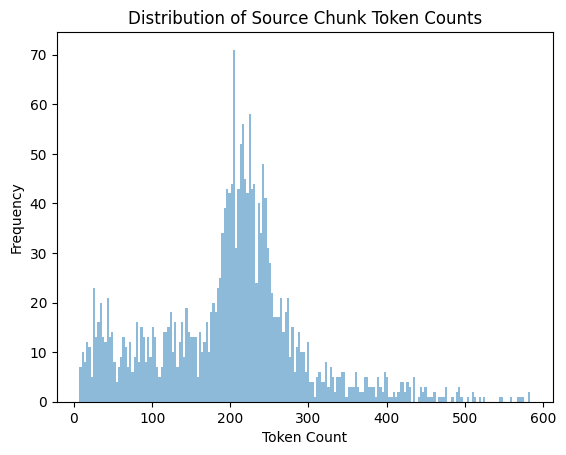

page_content='**1 Описание УИИ**\nУниверситет Искусственного Интеллекта - ведущее образовательное учреждение в России, специализирующееся исключительно на области искусственного интеллекта. Он
является самым крупным университетом по ИИ в России и странах СНГ, признанным лидером в образовании в сфере ИИ.\nПараллельно с созданием курсов на протяжении пяти лет УИИ активно занимается
разработкой в AI-сфере: создает AI-проекты для компаний на заказ.\n' metadata={'H1': '1 Описание УИИ (452 токенов)'}

page_content='УИИ не имеет филиалов за границей.\nКурсы в УИИ проходят студенты по всему миру.\nБолее 4700 студентов со всего мира выбрали УИИ для прохождения курса по AI. Они получают не только
теоретические знания, но и активно применяют их в создании проектов по искусственному интеллекту. Благодаря этому, студентами УИИ было создано уже 372 проекта в области ИИ.\nУниверситет также
предоставляет консультации более чем 100 крупным и малым компаниям, помогая им реализовывать и внедрять искусств

In [ ]:
# @title Диаграмма

# Посмотреть число чанков и их размер.
if True :
    # # Получение списка количества токенов в чанках.
    list_count = []
    list_count_plot = []
    for i, doc in enumerate(docs):
        list_count.append({"len":num_tokens_from_string(doc.page_content), "page_content": doc.page_content})
        list_count_plot.append(num_tokens_from_string(doc.page_content))
    # Изменить направление сортировки - от большего к меньшему.
    list_count_sort = sorted(list_count, key=lambda x: x["len"], reverse=True)[:10]
    print(f"Число чанков: {len(list_count)}")
    print(list_count_sort[0])
    a = sorted(list_count_plot, reverse=True)[:50]
    print(a)
    b = sorted(list_count_plot, reverse=False)[:50]
    print(b)


    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = list_count_plot
    plt.hist(source_chunk_token_counts, bins=200, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    for doc in docs[:2]:
        print(fill(str(doc), width=200))
        print()